In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines
import seaborn as sns
from intercluster.plotting import *

%load_ext autoreload
%autoreload 2

In [17]:
# This assumes tex is installed in your system, 
# if not you may simply remove most of this aside from font.size
# To get tex working on linux run the following:
# `sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super`
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 24
})

palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

subset_colors = [cmap(5), cmap(1), cmap(3), cmap(6), cmap(7), cmap(0), cmap(2)]
cmap_subset = ListedColormap(subset_colors)

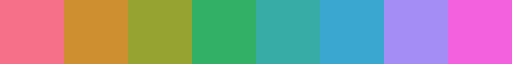

In [6]:
cmap

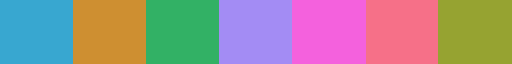

In [7]:
cmap_subset

### Coverage-Cost Experiments

In [79]:
# Load experiment results
dataset = 'fashion'
fname = "../data/experiments/" + dataset + "/relative_coverage/exp_updated.csv"
experiment_df = pd.read_csv(fname, header=[0, 1, 2, 3], index_col=0)

In [80]:
experiment_df

,max-rule-length,weighted-average-rule-length,normalized-clustering-cost,overlap,coverage,max-rule-length,weighted-average-rule-length,normalized-clustering-cost,overlap,coverage,...,max-rule-length,weighted-average-rule-length,normalized-clustering-cost,overlap,coverage,max-rule-length,weighted-average-rule-length,normalized-clustering-cost,overlap,coverage
,KMeans,KMeans,KMeans,KMeans,KMeans,IMM,IMM,IMM,IMM,IMM,...,IMM-outliers,IMM-outliers,IMM-outliers,IMM-outliers,IMM-outliers,IMM-outliers,IMM-outliers,IMM-outliers,IMM-outliers,IMM-outliers
,KMeans,KMeans,KMeans,KMeans,KMeans,IMM,IMM,IMM,IMM,IMM,...,KMeans,KMeans,KMeans,KMeans,KMeans,IMM,IMM,IMM,IMM,IMM
,0,0,0,0,0,0,0,0,0,0,...,99,99,99,99,99,99,99,99,99,99
0,NaN,NaN,31.929397,1.0,1.0,7,5.024,39.013473,1.0,1.0,...,NaN,NaN,23.497358,1.0,0.500000,7,5.024,30.464180,1.0,0.500000
1,NaN,NaN,31.929397,1.0,1.0,7,5.024,39.013473,1.0,1.0,...,NaN,NaN,24.503488,1.0,0.550143,7,5.024,31.713425,1.0,0.550143
2,NaN,NaN,31.929397,1.0,1.0,7,5.024,39.013473,1.0,1.0,...,NaN,NaN,25.371127,1.0,0.600000,7,5.024,32.728005,1.0,0.600000
3,NaN,NaN,31.929397,1.0,1.0,7,5.024,39.013473,1.0,1.0,...,NaN,NaN,26.179035,1.0,0.650000,7,5.024,33.661833,1.0,0.650000
4,NaN,NaN,31.929397,1.0,1.0,7,5.024,39.013473,1.0,1.0,...,NaN,NaN,27.018019,1.0,0.700000,7,5.024,34.496032,1.0,0.700000
5,NaN,NaN,31.929397,1.0,1.0,7,5.024,39.013473,1.0,1.0,...,NaN,NaN,27.922601,1.0,0.750000,7,5.024,35.435417,1.0,0.750000
6,NaN,NaN,31.929397,1.0,1.0,7,5.024,39.013473,1.0,1.0,...,NaN,NaN,28.827997,1.0,0.800143,7,5.024,36.312481,1.0,0.800143


In [81]:
# Compute statistics:
grouped = experiment_df.T.groupby(level = [0,1,2])
mean_df = grouped.mean().T
std_df = grouped.std().T

In [82]:
table_df = mean_df.iloc[-5,:].to_frame()
table_df.loc['max-rule-length',:]

6
Forest-Depth-2   Forest-Depth-2    2.0
                 IMM               7.0
                 KMeans            NaN
Forest-Depth-4   Forest-Depth-4    4.0
                 IMM               7.0
                 KMeans            NaN
Forest-Depth-6   Forest-Depth-6    6.0
                 IMM               7.0
                 KMeans            NaN
Forest-Depth-IMM Forest-Depth-IMM  7.0
                 IMM               7.0
                 KMeans            NaN
IMM              IMM               7.0
IMM-outliers     IMM               7.0
                 IMM-outliers      7.0
                 KMeans            NaN
KMeans           KMeans            NaN

In [31]:
domain_df

,Forest,IMM,KMeans,KMeans-Full,IMM-Full
0,0.50,0.50,0.50,0.50,0.50
1,0.55,0.55,0.55,0.55,0.55
2,0.60,0.60,0.60,0.60,0.60
3,0.65,0.65,0.65,0.65,0.65
4,0.70,0.70,0.70,0.70,0.70
5,0.75,0.75,0.75,0.75,0.75
6,0.80,0.80,0.80,0.80,0.80
7,0.85,0.85,0.85,0.85,0.85
8,0.90,0.90,0.90,0.90,0.90
9,0.95,0.95,0.95,0.95,0.95


### Plotting

In [40]:
#colormap = no_oblique_cmap_subset
#module_list = [m for m in mean_df['normalized-clustering-cost'].columns if m not in baseline_list]
#module_list = [m for m in mean_df['normalized-clustering-cost'][model].columns]

colormap = cmap_subset
baseline_list = ['KMeans-Full', 'IMM-Full']
module_list = ['KMeans', 'IMM', 'Forest-Depth-2', 
               'Forest-Depth-4','Forest-Depth-6', 'Forest-Depth-IMM','IMM-outliers']
color_dict = {mod : i for i,mod in enumerate(module_list)}

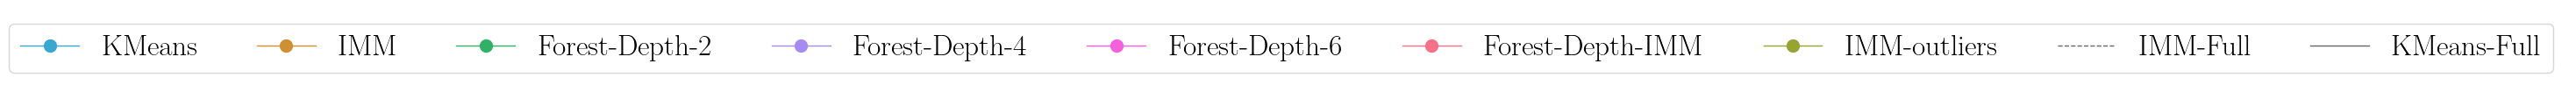

In [18]:
# Legend:
fig, ax = plt.subplots(figsize = (6,1))
legend_elements = [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=10,
        color=colormap(i),
        lw=1,
        label=mod,
        alpha=1
    )
    for i,mod in enumerate(module_list)
]

legend_elements += [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=0,
        color='k',
        lw=1,
        linestyle = 'dashed',
        label="IMM-Full",
        alpha=0.6
    )
]

legend_elements += [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=0,
        color='k',
        lw=1,
        linestyle = '-',
        label="KMeans-Full",
        alpha=0.6
    )
]

ax.legend(handles=legend_elements, ncol=len(module_list) + len(baseline_list))
ax.axis('off')
plt.savefig('../figures/relative_coverage/legend.png', bbox_inches = 'tight', dpi = 300)

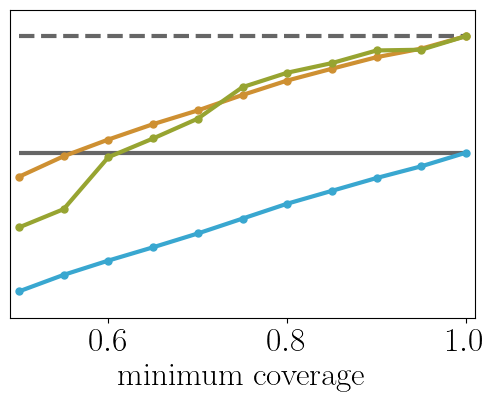

In [88]:
model = 'IMM-outliers'
measure = 'normalized-clustering-cost'
#measure = 'silhouette'
xlabel = 'minimum coverage'
ylabel = measure if measure != 'normalized-clustering-cost' else 'cost'
fname = '../figures/relative_coverage/' + ylabel + '/' + dataset + '/' + model + '.png'
#fname = None

xaxis = True
yaxis = False
if not xaxis:
    xlabel = ''
if not yaxis:
    ylabel = ''

plot_colors = [colormap(color_dict[mod]) for mod in mean_df[measure][model].columns]
plot_cmap = ListedColormap(plot_colors)
measure_df = mean_df[measure]

# Measurements
if measure == 'normalized-clustering-cost':
    norm = mean_df[measure]['KMeans']['KMeans'].iloc[0]
else:
    norm = 1

measure_df = mean_df[measure] / norm

plot_df = mean_df[measure][model]
plot_df['KMeans-Full'] = mean_df[measure]['KMeans']
plot_df['IMM-Full'] = mean_df[measure]['IMM']
plot_df /= norm

plot_std_df = std_df[measure][model]
plot_std_df['KMeans-Full'] = std_df[measure]['KMeans']
plot_std_df['IMM-Full'] = std_df[measure]['IMM']
plot_std_df /= norm

# Domain:
#domain_df = mean_df['coverage'][model]
domain_array = np.array([list(np.linspace(0.5,1,11))] * len(plot_df.columns)).T
domain_df = pd.DataFrame(domain_array, columns = plot_df.columns)

xlim = (0.49, 1.01)
ylim = (measure_df.min().min() - 0.05, measure_df.max().max() + 0.05)
experiment_plotter(
    plot_df,
    plot_std_df,
    domain_df,
    xlabel = xlabel,
    ylabel = ylabel,
    cmap = plot_cmap,
    baseline_list = ['KMeans-Full', 'IMM-Full'],
    legend = False,
    xlim = xlim,
    ylim = ylim,
    xaxis = xaxis,
    yaxis = yaxis,
    filename = fname,
)

In [45]:
measure_df.iloc[:-1,:].min().min()

0.5994177894081568

In [43]:
measure_df.iloc[:-1,:]

Forest-Depth-2                     Forest-Depth-4                      \
  Forest-Depth-2       IMM    KMeans Forest-Depth-4       IMM    KMeans   
0       0.913199  0.952760  0.907564       0.954897  0.997778  0.953366   
1       0.913199  0.952760  0.907564       0.954897  0.997778  0.953366   
2       0.913144  0.952588  0.907400       0.954897  0.997778  0.953366   
3       0.933855  0.966643  0.922464       0.954897  0.997778  0.953366   
4       0.941768  0.963070  0.924924       0.954897  0.997778  0.953366   
5       0.943795  0.963618  0.925460       0.955541  0.998474  0.953913   
6       0.947010  0.967484  0.927893       0.968245  1.011611  0.962904   
7       0.984088  1.003861  0.955180       0.983210  1.023799  0.972347   
8       1.025808  1.029643  0.975669       1.007274  1.040509  0.987615   
9       1.050404  1.040421  0.986173       1.027951  1.045777  0.991564   

  Forest-Depth-6                     Forest-Depth-IMM                      \
  Forest-Depth-6       IMM    KMeans Forest-Depth-IMM       IMM    KMeans   
0       0.959099  1.003779  0.958307         0.956948  1.000966  0.955893   
1       0.959099  1.003779  0.958307         0.956948  1.000966  0.955893   
2       0.959099  1.003779  0.958307         0.956948  1.000966  0.955893   
3       0.959099  1.003779  0.958307         0.956948  1.000966  0.955893   
4       0.959099  1.003779  0.958307         0.956948  1.000966  0.955893   
5       0.959099  1.003779  0.958307         0.957047  1.001056  0.955973   
6       0.961706  1.006859  0.960309         0.962697  1.007255  0.960106   
7       0.982240  1.027696  0.976614         0.982616  1.026062  0.975459   
8       1.004813  1.042282  0.989587         1.005673  1.041641  0.989201   
9       1.029742  1.046504  0.992240         1.028840  1.046183  0.991742   

        IMM IMM-outliers                        KMeans  
        IMM          IMM IMM-outliers    KMeans KMeans  
0  1.054999     0.611483     0.599418  0.599418    1.0  
1  1.054999     0.656202     0.633585  0.633585    1.0  
2  1.054999     0.727449     0.691412  0.681718    1.0  
3  1.054999     0.776510     0.753359  0.715553    1.0  
4  1.054999     0.854952     0.834616  0.801146    1.0  
5  1.054999     0.886185     0.879428  0.830791    1.0  
6  1.054999     0.924107     0.914725  0.859588    1.0  
7  1.054999     0.974387     0.962357  0.910514    1.0  
8  1.054999     1.006210     0.997370  0.942473    1.0  
9  1.054999     1.029497     1.029497  0.969937    1.0

In [68]:
plot_df.min().min()

0.04956912864914474

(10.0, 14.0)

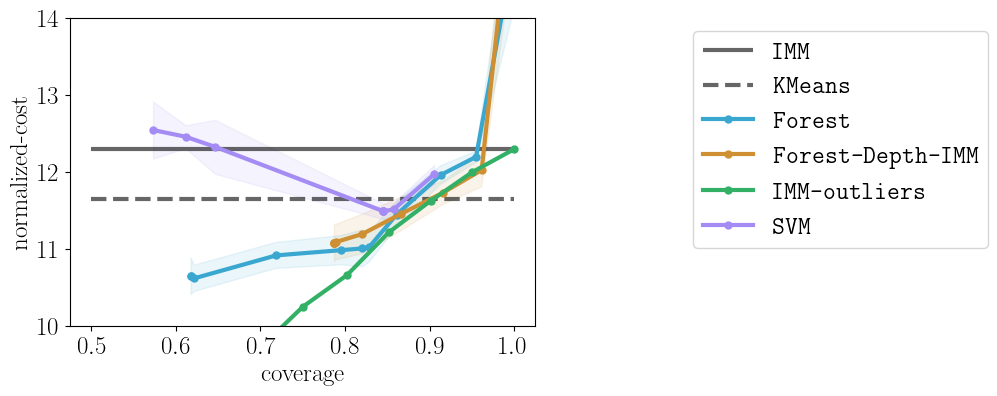

In [31]:
fname = None
#fname = '../figures/coverage/fashion.png'
experiment_plotter(
    mean_df['normalized-clustering-cost'],
    std_df['normalized-clustering-cost'],
    domain_df = mean_df['coverage'],
    xlabel = 'coverage',
    ylabel = 'normalized-cost',
    cmap = colormap,
    baseline_list = ['KMeans', 'IMM'],
    legend = True,
    filename = fname,
)
plt.ylim(10,14)